## Training Deep Neural Networks

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Vanishing/Exploding Gradients Problem

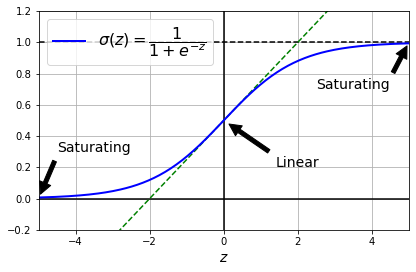

In [6]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

In [7]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [8]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

### Leaky ReLU

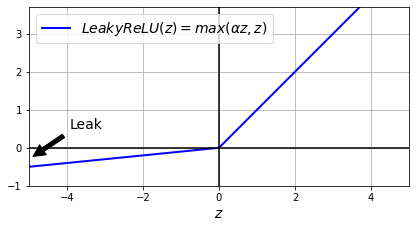

In [9]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [10]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [11]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU

In [12]:

dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

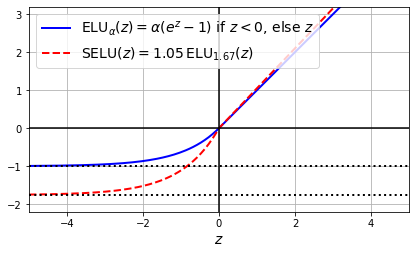

In [13]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

In [14]:

dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

In [16]:
#Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [18]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [21]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 30s 13ms/step - loss: 1.3239 - accuracy: 0.4778 - val_loss: 0.8540 - val_accuracy: 0.7044
Epoch 2/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.7523 - accuracy: 0.7245 - val_loss: 0.6362 - val_accuracy: 0.7654
Epoch 3/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.6405 - accuracy: 0.7691 - val_loss: 0.6108 - val_accuracy: 0.7748
Epoch 4/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.5646 - accuracy: 0.7989 - val_loss: 0.5574 - val_accuracy: 0.8086
Epoch 5/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.5315 - accuracy: 0.8163 - val_loss: 0.5188 - val_accuracy: 0.8208


In [24]:
tf.random.set_seed(42)

In [25]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [27]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 21s 10ms/step - loss: 1.8799 - accuracy: 0.2079 - val_loss: 1.8777 - val_accuracy: 0.2110
Epoch 2/5
1719/1719 [==============================] - 16s 10ms/step - loss: 1.7040 - accuracy: 0.2790 - val_loss: 1.2524 - val_accuracy: 0.4524
Epoch 3/5
1719/1719 [==============================] - 17s 10ms/step - loss: 1.2026 - accuracy: 0.4709 - val_loss: 1.0242 - val_accuracy: 0.5372
Epoch 4/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.9576 - accuracy: 0.5755 - val_loss: 0.8711 - val_accuracy: 0.6412
Epoch 5/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.9313 - accuracy: 0.6188 - val_loss: 0.9605 - val_accuracy: 0.5890


The Gaussian Error Linear Unit, or GELU, is an activation function. The GELU activation function is , where the standard Gaussian cumulative distribution function. The GELU nonlinearity weights inputs by their percentile, rather than gates inputs by their sign as in ReLUs. Consequently the GELU can be thought of as a smoother ReLU.

PyTorch's exact implementation is sufficiently fast such that these approximations may be unnecessary. (See also the SiLU which was also coined in the paper that introduced the GELU.)

GELUs are used in GPT-3, BERT, and most other Transformers.

Swish is an activation function,  f(x) = x . sigmoid(beta . x) where beta a learnable parameter. Nearly all implementations do not use the learnable parameter, in which case the activation function is xsigma(x) ("Swish-1").

The function xsigma(x) is exactly the SiLU, which was introduced by other authors before the swish. See Gaussian Error Linear Units (GELUs) where the SiLU (Sigmoid Linear Unit) was originally coined, and see Sigmoid-Weighted Linear Units for Neural Network Function Approximation in Reinforcement Learning and Swish: a Self-Gated Activation Function where the same activation function was experimented with later.

Mish is an activation function for neural networks which can be defined as:
                                  f(x) = x tanh softplus(x)

where
                                    softplus(x) = ln(1+e^x)

(Compare with functionally similar previously proposed activation functions such as the GELU and the SiLU.)

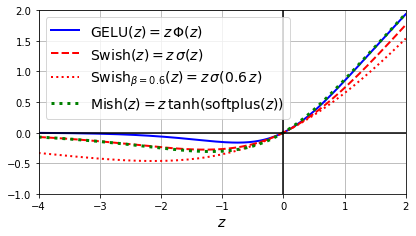

In [28]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [32]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [33]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5505 - accuracy: 0.8087 - val_loss: 0.3901 - val_accuracy: 0.8504
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4035 - accuracy: 0.8560 - val_loss: 0.3490 - val_accuracy: 0.8672


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer some as well, it would be a waste of parameters, so you can set use_bias=False when creating those layers:

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6121 - accuracy: 0.7955 - val_loss: 0.4314 - val_accuracy: 0.8516
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4299 - accuracy: 0.8501 - val_loss: 0.3792 - val_accuracy: 0.8634


## Gradient Clipping

In [38]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:

X_train_A: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
X_train_B: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.
The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [39]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 3s 2ms/step - loss: 1.2672 - accuracy: 0.6127 - val_loss: 0.7651 - val_accuracy: 0.7716
Epoch 2/20
1376/1376 [==============================] - 2s 2ms/step - loss: 0.6443 - accuracy: 0.7954 - val_loss: 0.5416 - val_accuracy: 0.8228
Epoch 3/20
1376/1376 [==============================] - 2s 2ms/step - loss: 0.5077 - accuracy: 0.8373 - val_loss: 0.4601 - val_accuracy: 0.8453
Epoch 4/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.4427 - accuracy: 0.8561 - val_loss: 0.4128 - val_accuracy: 0.8629
Epoch 5/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.4026 - accuracy: 0.8674 - val_loss: 0.3833 - val_accuracy: 0.8704
Epoch 6/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3746 - accuracy: 0.8759 - val_loss: 0.3623 - val_accuracy: 0.8737
Epoch 7/20
1376/1376 [==============================] - 2s 2ms/step - loss: 0.3544 - accuracy: 0.8802 - val_loss: 0.3455 - val_accuracy:

In [40]:
tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 41ms/step - loss: 0.8148 - accuracy: 0.5550 - val_loss: 0.7945 - val_accuracy: 0.5153
Epoch 2/20
7/7 [==============================] - 0s 15ms/step - loss: 0.7381 - accuracy: 0.5550 - val_loss: 0.7351 - val_accuracy: 0.5153
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6894 - accuracy: 0.5550 - val_loss: 0.6988 - val_accuracy: 0.5163
Epoch 4/20
7/7 [==============================] - 0s 13ms/step - loss: 0.6572 - accuracy: 0.5550 - val_loss: 0.6691 - val_accuracy: 0.5163
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.6321 - accuracy: 0.5550 - val_loss: 0.6446 - val_accuracy: 0.5193
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.6110 - accuracy: 0.5600 - val_loss: 0.6239 - val_accuracy: 0.5598
Epoch 7/20
7/7 [==============================] - 0s 16ms/step - loss: 0.5931 - accuracy: 0.6250 - val_loss: 0.6060 - val_accuracy: 0.6291
Epoch 8/20
7/7 [===========

[0.4892318844795227, 0.8654999732971191]

In [41]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [42]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

In [43]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [44]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [45]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [46]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 40ms/step - loss: 0.9103 - accuracy: 0.4700 - val_loss: 0.7621 - val_accuracy: 0.5163
Epoch 2/4
7/7 [==============================] - 0s 15ms/step - loss: 0.6853 - accuracy: 0.5500 - val_loss: 0.6607 - val_accuracy: 0.5984
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 0.6152 - accuracy: 0.6500 - val_loss: 0.6307 - val_accuracy: 0.6637
Epoch 4/4
7/7 [==============================] - 0s 15ms/step - loss: 0.5892 - accuracy: 0.7550 - val_loss: 0.6223 - val_accuracy: 0.6835
Epoch 1/16
7/7 [==============================] - 1s 41ms/step - loss: 0.5673 - accuracy: 0.7550 - val_loss: 0.5825 - val_accuracy: 0.7280
Epoch 2/16
7/7 [==============================] - 0s 15ms/step - loss: 0.5267 - accuracy: 0.8150 - val_loss: 0.5374 - val_accuracy: 0.7992
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.4880 - accuracy: 0.8450 - val_loss: 0.5073 - val_accuracy: 0.8279
Epoch 4/16
7/7 [===============

In [47]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.3182 - accuracy: 0.9270


[0.31818336248397827, 0.9269999861717224]

In [48]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477